# **Computer Assignment 5, Phase 2, Diagnosis of lung diseases using neural networks**

##1.   Loading and processing data






In [4]:
from google.colab import drive
from tensorflow.keras import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!cp '/content/drive/MyDrive/xray.zip' .

In [ ]:
!unzip xray.zip

In [10]:
def getAllData(size=(80,80), batch_size=32, scale=None, shuffle=True):
  dataGenerator = preprocessing.image.ImageDataGenerator(rescale=scale)
  dataTrain = dataGenerator.flow_from_directory(
    '/content/Data/train',
    target_size=size,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=shuffle
  )
  dataTest = dataGenerator.flow_from_directory(
    '/content/Data/test',
    target_size=size,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=shuffle
  )
  return dataTrain, dataTest

In [116]:
dataTrain, dataTest = getAllData()

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [119]:
dataTrainSorted, dataTestSorted = getAllData(shuffle=False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


##2.   Analyze each category





   ### Picture of each category

---













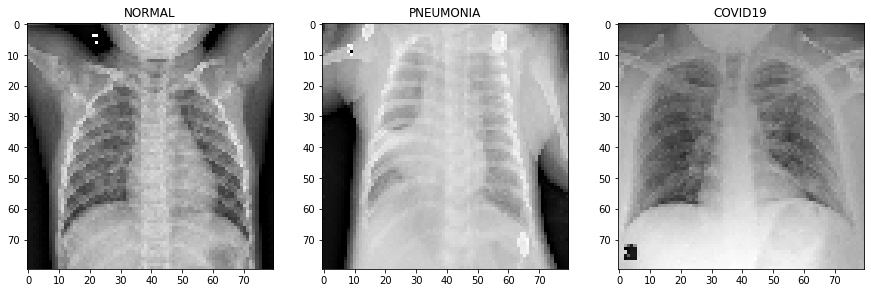

In [111]:
BATCH_SIZE = 32

picCategories = dict()
categories = {0 : 'COVID19', 1 : 'NORMAL', 2 : 'PNEUMONIA'}

for data, labels in dataTrain:
  for i in range(BATCH_SIZE):
    picCategory = categories[labels[i].argmax()]
    if picCategory not in picCategories:
      picCategories[picCategory] = data[i]
    if len(picCategories) == 3:
      break
  if len(picCategories) == 3:
      break

f, axarr = plt.subplots(1,3, figsize=(15,15))
pltNum = 0
for category in picCategories:
  image = preprocessing.image.array_to_img(picCategories[category])
  axarr[pltNum].set_title(category)
  axarr[pltNum].imshow(image, cmap='gray')
  pltNum +=1
plt.show()

### Number of images per category


---



<BarContainer object of 3 artists>

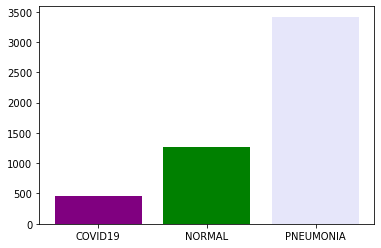

In [9]:
categoryStat = dict()
categories = {0 : 'COVID19', 1 : 'NORMAL', 2 : 'PNEUMONIA'}

for label in dataTrain.classes:
  if categories[label] in categoryStat:
    categoryStat[categories[label]] += 1
  else:
    categoryStat[categories[label]] = 0

plt.bar(list(categoryStat.keys()), list(categoryStat.values()), color=['purple', 'green', 'lavender'])

##3.   Implementation of neural network structure



In [21]:
def createModel(hiddenLayersShape,
                activationFunc='relu', 
                inputShape=(1,80,80), 
                optimizerFunc=optimizers.SGD(learning_rate=0.01), 
                lossFunc='categorical_crossentropy', 
                numberOfClass=3, 
                metrics=['accuracy']):
  
  inputLayer = layers.Input(shape=inputShape)
  flattenLayer = layers.Flatten()(inputLayer)
  hiddenLayers = [inputLayer, flattenLayer]

  for layerShape in hiddenLayersShape :
    hiddenLayers.append(layers.Dense(layerShape, activation=activationFunc)(hiddenLayers[-1]))
  
  outputLayer = layers.Dense(numberOfClass, activation="softmax")(hiddenLayers[-1])

  model = models.Model(inputs=inputLayer, outputs=outputLayer)

  model.compile(optimizer=optimizerFunc, loss=lossFunc, metrics=metrics)

  return model

In [7]:
def fitModel(model, trainData, testData, epochs=10):
  modelHistory = model.fit(trainData, validation_data=testData, epochs=epochs)
  return modelHistory, model

In [19]:
def plotMetrics(history, epochs):
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_figheight(5)
  fig.set_figwidth(12)
  fig.tight_layout(pad=5.0)

  metricName = 'accuracy'

  ax1.plot(range(1, epochs+1), history[metricName], history['val_' + metricName])
  ax1.set_ylabel(metricName)
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'test'])
        
  metricName = 'loss'
  ax2.plot(range(1, epochs+1), history[metricName], history['val_' + metricName])
  ax2.set_ylabel(metricName)
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'test'])
        
  fig.show()

In [20]:
def displayModelResult(modelHistory, model, trainData, testData, epochs=10):
  plotMetrics(modelHistory.history, epochs)

  expectedTrain = trainData.classes
  expectedTest = testData.classes

  predictedTrain = np.argmax(model.predict(trainData), axis=1)
  print('Train data predictions are:')
  print(predictedTrain)

  print('Train data expection are:')
  print(expectedTrain)

  predictedTest = np.argmax(model.predict(testData), axis=1)
  print('Test data predictions are:')
  print(predictedTest)

  print('Test data expection are:')
  print(expectedTest)

  print('Train Data Report:')
  print(classification_report(expectedTrain, predictedTrain))

  print('Test Data Report:')
  print(classification_report(expectedTest, predictedTest))

In [21]:
model3 = createModel([2048, 1024, 1024])
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 80, 80)]       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              13109248  
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 3075      
Total params: 16,260,099
Trainable params: 16,260,099
Non-trainable params: 0
_______________________________________________

The parameters of each layer consist of number of weights and number of bias. For example, in layer 3, the number of weights is equal to: 
$2048 \times 6400 = 13107200$
And the number of bias is equal to:
$2048$
So the total number of parameters is:
$13107200 + 2048 = 13109248$

##4.   Different Activation Functions


###Relu


---






In [98]:
model4_1 = createModel([2048, 1024, 1024])
history4_1, fitModel4_1 = fitModel(model4_1, trainData=dataTrain, testData=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 143s 887ms/step - loss: nan - accuracy: 0.1299 - val_loss: nan - val_accuracy: 0.0901
Epoch 2/10
161/161 [==============================] - 142s 878ms/step - loss: nan - accuracy: 0.0941 - val_loss: nan - val_accuracy: 0.0901
Epoch 3/10
161/161 [==============================] - 142s 883ms/step - loss: nan - accuracy: 0.0917 - val_loss: nan - val_accuracy: 0.0901
Epoch 4/10
161/161 [==============================] - 142s 884ms/step - loss: nan - accuracy: 0.0856 - val_loss: nan - val_accuracy: 0.0901
Epoch 5/10
161/161 [==============================] - 142s 884ms/step - loss: nan - accuracy: 0.0892 - val_loss: nan - val_accuracy: 0.0901
Epoch 6/10
161/161 [==============================] - 142s 884ms/step - loss: nan - accuracy: 0.0934 - val_loss: nan - val_accuracy: 0.0901
Epoch 7/10
161/161 [==============================] - 142s 885ms/step - loss: nan - accuracy: 0.0915 - val_loss: nan - val_accuracy: 0.0901
Epoch 8/10
161/161 [

Train data predictions are:
[0 0 0 ... 0 0 0]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[0 0 0 ... 0 0 0]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.09      1.00      0.16       460
           1       0.00      0.00      0.00      1266
           2       0.00      0.00      0.00      3418

    accuracy                           0.09      5144
   macro avg       0.03      0.33      0.05      5144
weighted avg       0.01      0.09      0.01      5144

Test Data Report:
              precision    recall  f1-score   support

           0       0.09      1.00      0.17       116
           1       0.00      0.00      0.00       317
           2       0.00      0.00      0.00       855

    accuracy                           0.09      1288
   macro avg       0.03      0.33      0.06      1288
weighted avg       0.01      0.09      0.01      1288



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


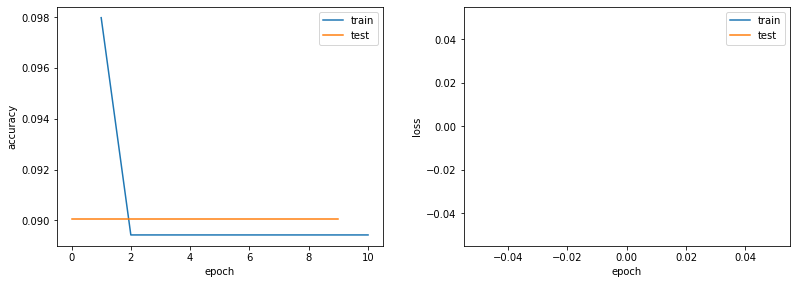

In [122]:
displayModelResult(history4_1, fitModel4_1, dataTrainSorted, dataTestSorted, epochs=10)

### Tanh


---



In [123]:
model4_2 = createModel([2048, 1024, 1024], activationFunc='tanh')
history4_2, fitModel4_2 = fitModel(model4_2, trainData=dataTrain, testData=dataTest, epochs=10)

Epoch 1/10
161/161 [==============================] - 143s 888ms/step - loss: 1.6140 - accuracy: 0.5415 - val_loss: 0.9417 - val_accuracy: 0.6638
Epoch 2/10
161/161 [==============================] - 143s 887ms/step - loss: 0.9366 - accuracy: 0.6297 - val_loss: 0.9290 - val_accuracy: 0.6638
Epoch 3/10
161/161 [==============================] - 142s 886ms/step - loss: 0.9269 - accuracy: 0.5980 - val_loss: 0.9512 - val_accuracy: 0.6638
Epoch 4/10
161/161 [==============================] - 142s 885ms/step - loss: 0.8814 - accuracy: 0.6483 - val_loss: 0.8343 - val_accuracy: 0.6638
Epoch 5/10
161/161 [==============================] - 142s 885ms/step - loss: 0.8728 - accuracy: 0.6450 - val_loss: 0.9091 - val_accuracy: 0.6638
Epoch 6/10
161/161 [==============================] - 142s 885ms/step - loss: 0.8542 - accuracy: 0.6612 - val_loss: 0.8438 - val_accuracy: 0.6638
Epoch 7/10
161/161 [==============================] - 142s 882ms/step - loss: 0.8551 - accuracy: 0.6627 - val_loss: 0.8541 -

Train data predictions are:
[2 2 2 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 2 2 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144

Test Data Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


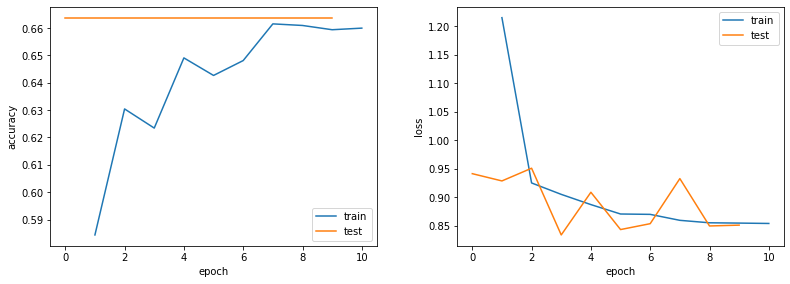

In [124]:
displayModelResult(history4_2, fitModel4_2, dataTrainSorted, dataTestSorted, epochs=10)



###   Compare Relu and Tanh Results


---





Because the activation of the Relu method maximizes between zero and its input, it overflows for large inputs. But Tanh does not have this problem because its output is a limited value, and as we can see, the value of loss is calculated for it without any problem.

The performance of both models is significantly poor due to the lack of normalization of data. In this case, large amounts of data have a much greater impact on the result, which is unpleasant and causes us to get the wrong result.
In the next step, by normalizing the data, we see how much better the result is.

## 5.   Normalize Data

In [15]:
dataTrainNormalized, dataTestNormalized = getAllData(scale=1/255)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [16]:
dataTrainNormalizedSorted, dataTestNormalizedSorted = getAllData(scale=1/255, shuffle=False)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [127]:
model5 = createModel([2048, 1024, 1024])
history5, fitModel5 = fitModel(model5, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=10)

Epoch 1/10
161/161 [==============================] - 143s 889ms/step - loss: 0.6903 - accuracy: 0.7065 - val_loss: 0.3713 - val_accuracy: 0.8571
Epoch 2/10
161/161 [==============================] - 143s 891ms/step - loss: 0.4255 - accuracy: 0.8348 - val_loss: 0.2916 - val_accuracy: 0.8750
Epoch 3/10
161/161 [==============================] - 142s 884ms/step - loss: 0.3676 - accuracy: 0.8438 - val_loss: 0.2225 - val_accuracy: 0.9169
Epoch 4/10
161/161 [==============================] - 143s 890ms/step - loss: 0.3082 - accuracy: 0.8816 - val_loss: 0.1971 - val_accuracy: 0.9301
Epoch 5/10
161/161 [==============================] - 142s 886ms/step - loss: 0.2833 - accuracy: 0.8869 - val_loss: 0.1852 - val_accuracy: 0.9356
Epoch 6/10
161/161 [==============================] - 143s 887ms/step - loss: 0.2834 - accuracy: 0.8916 - val_loss: 0.1806 - val_accuracy: 0.9402
Epoch 7/10
161/161 [==============================] - 142s 884ms/step - loss: 0.2449 - accuracy: 0.9003 - val_loss: 0.3503 -

Train data predictions are:
[2 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 0 0 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       460
           1       0.93      0.75      0.83      1266
           2       0.90      0.99      0.94      3418

    accuracy                           0.91      5144
   macro avg       0.93      0.85      0.89      5144
weighted avg       0.91      0.91      0.91      5144

Test Data Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87       116
           1       0.93      0.79      0.85       317
           2       0.91      0.99      0.95       855

    accuracy                           0.92      1288
   macro avg       0.95      0.85      0.89      1288
weighted avg       0.92      0.92      0.92      1288



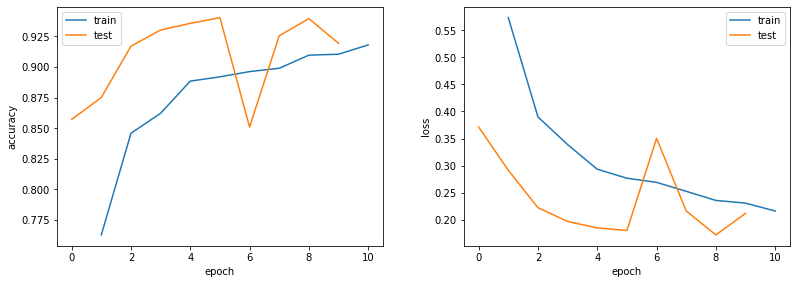

In [128]:
displayModelResult(history5, fitModel5, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=10)

In [129]:
model5_2 = createModel([2048, 1024, 4096, 1024])
history5_2, fitModel5_2 = fitModel(model5_2, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=10)

Epoch 1/10
161/161 [==============================] - 144s 890ms/step - loss: 0.6742 - accuracy: 0.7041 - val_loss: 0.4711 - val_accuracy: 0.7787
Epoch 2/10
161/161 [==============================] - 142s 880ms/step - loss: 0.4217 - accuracy: 0.8257 - val_loss: 0.4050 - val_accuracy: 0.8199
Epoch 3/10
161/161 [==============================] - 146s 901ms/step - loss: 0.3243 - accuracy: 0.8754 - val_loss: 0.2670 - val_accuracy: 0.9030
Epoch 4/10
161/161 [==============================] - 144s 890ms/step - loss: 0.2879 - accuracy: 0.8927 - val_loss: 0.1906 - val_accuracy: 0.9332
Epoch 5/10
161/161 [==============================] - 144s 892ms/step - loss: 0.2727 - accuracy: 0.8970 - val_loss: 0.1860 - val_accuracy: 0.9348
Epoch 6/10
161/161 [==============================] - 142s 884ms/step - loss: 0.2457 - accuracy: 0.9069 - val_loss: 0.2098 - val_accuracy: 0.9161
Epoch 7/10
161/161 [==============================] - 142s 882ms/step - loss: 0.2434 - accuracy: 0.9051 - val_loss: 0.2272 -

Train data predictions are:
[2 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 0 0 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       460
           1       0.92      0.83      0.87      1266
           2       0.92      0.98      0.95      3418

    accuracy                           0.93      5144
   macro avg       0.94      0.87      0.90      5144
weighted avg       0.93      0.93      0.93      5144

Test Data Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       116
           1       0.92      0.88      0.90       317
           2       0.94      0.98      0.96       855

    accuracy                           0.94      1288
   macro avg       0.95      0.88      0.91      1288
weighted avg       0.94      0.94      0.94      1288



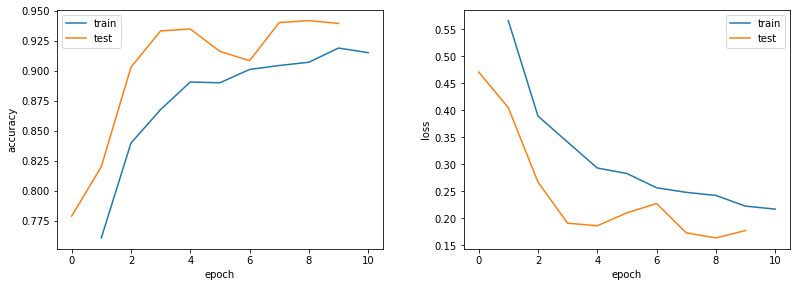

In [130]:
displayModelResult(history5_2, fitModel5_2, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=10)

##6. Optimizers



*   **Momentum**  is an added term in the objective function, which is a value between 0 and 1 that increases the size of the steps taken towards the minimum by trying to jump from a local minimum. </br>
Essentially, when using momentum, we push a ball down a hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way (until it reaches its terminal velocity if there is air resistance, i.e. 
γ
<
1
). The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.



Momentum = 0.5


---



In [131]:
model6_1 = createModel([2048, 1024, 4096, 1024], optimizerFunc=optimizers.SGD(learning_rate=0.01, momentum=0.5))
history6_1, fitModel6_1 = fitModel(model6_1, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=10)

Epoch 1/10
161/161 [==============================] - 143s 885ms/step - loss: 0.6189 - accuracy: 0.7449 - val_loss: 0.3518 - val_accuracy: 0.8540
Epoch 2/10
161/161 [==============================] - 142s 881ms/step - loss: 0.3511 - accuracy: 0.8649 - val_loss: 0.2405 - val_accuracy: 0.9061
Epoch 3/10
161/161 [==============================] - 141s 880ms/step - loss: 0.3091 - accuracy: 0.8809 - val_loss: 0.2076 - val_accuracy: 0.9363
Epoch 4/10
161/161 [==============================] - 142s 881ms/step - loss: 0.2563 - accuracy: 0.8946 - val_loss: 0.1777 - val_accuracy: 0.9394
Epoch 5/10
161/161 [==============================] - 142s 884ms/step - loss: 0.2388 - accuracy: 0.9139 - val_loss: 0.2114 - val_accuracy: 0.9130
Epoch 6/10
161/161 [==============================] - 142s 880ms/step - loss: 0.2463 - accuracy: 0.9060 - val_loss: 0.2078 - val_accuracy: 0.9169
Epoch 7/10
161/161 [==============================] - 141s 878ms/step - loss: 0.2095 - accuracy: 0.9203 - val_loss: 0.3279 -

Train data predictions are:
[2 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 0 0 ... 1 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       460
           1       0.86      0.93      0.89      1266
           2       0.96      0.95      0.95      3418

    accuracy                           0.93      5144
   macro avg       0.93      0.90      0.92      5144
weighted avg       0.94      0.93      0.93      5144

Test Data Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       116
           1       0.88      0.93      0.90       317
           2       0.96      0.96      0.96       855

    accuracy                           0.94      1288
   macro avg       0.94      0.90      0.92      1288
weighted avg       0.94      0.94      0.94      1288



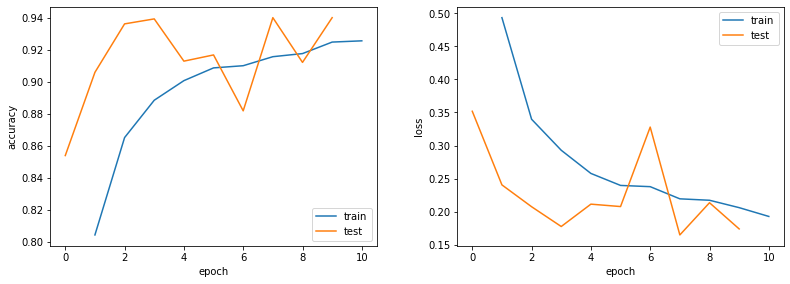

In [132]:
displayModelResult(history6_1, fitModel6_1, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=10)

Momentum = 0.9


---



In [133]:
model6_2 = createModel([2048, 1024, 4096, 1024], optimizerFunc=optimizers.SGD(learning_rate=0.01, momentum=0.9))
history6_2, fitModel6_2 = fitModel(model6_2, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=10)

Epoch 1/10
161/161 [==============================] - 143s 884ms/step - loss: 0.5844 - accuracy: 0.7628 - val_loss: 0.2839 - val_accuracy: 0.9161
Epoch 2/10
161/161 [==============================] - 141s 877ms/step - loss: 0.3802 - accuracy: 0.8534 - val_loss: 0.2732 - val_accuracy: 0.8789
Epoch 3/10
161/161 [==============================] - 141s 878ms/step - loss: 0.2574 - accuracy: 0.9001 - val_loss: 0.3818 - val_accuracy: 0.8416
Epoch 4/10
161/161 [==============================] - 142s 883ms/step - loss: 0.2730 - accuracy: 0.8943 - val_loss: 0.2636 - val_accuracy: 0.8820
Epoch 5/10
161/161 [==============================] - 142s 881ms/step - loss: 0.2436 - accuracy: 0.9085 - val_loss: 0.1860 - val_accuracy: 0.9301
Epoch 6/10
161/161 [==============================] - 142s 884ms/step - loss: 0.2170 - accuracy: 0.9261 - val_loss: 0.2912 - val_accuracy: 0.8820
Epoch 7/10
161/161 [==============================] - 142s 881ms/step - loss: 0.2239 - accuracy: 0.9180 - val_loss: 0.1650 -

Train data predictions are:
[0 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 0 0 ... 1 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       460
           1       0.69      0.97      0.81      1266
           2       0.98      0.84      0.90      3418

    accuracy                           0.88      5144
   macro avg       0.87      0.89      0.87      5144
weighted avg       0.90      0.88      0.88      5144

Test Data Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       116
           1       0.75      0.97      0.84       317
           2       0.98      0.88      0.93       855

    accuracy                           0.90      1288
   macro avg       0.90      0.91      0.90      1288
weighted avg       0.92      0.90      0.91      1288



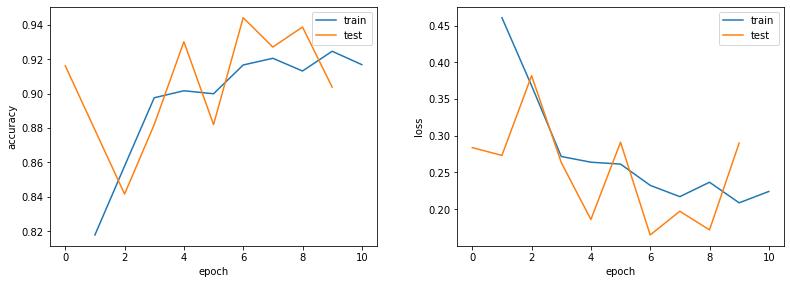

In [134]:
displayModelResult(history6_2, fitModel6_2, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=10)

Momentum = 0.99


---

In [23]:
model6_3 = createModel([2048, 1024, 4096, 1024], optimizerFunc=optimizers.SGD(learning_rate=0.01, momentum=0.99))
history6_3, fitModel6_3 = fitModel(model6_3, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=10)

Epoch 1/10
161/161 [==============================] - 145s 897ms/step - loss: 0.7139 - accuracy: 0.7003 - val_loss: 0.4588 - val_accuracy: 0.8362
Epoch 2/10
161/161 [==============================] - 144s 896ms/step - loss: 0.4821 - accuracy: 0.8153 - val_loss: 0.2227 - val_accuracy: 0.9247
Epoch 3/10
161/161 [==============================] - 143s 889ms/step - loss: 0.3889 - accuracy: 0.8596 - val_loss: 0.2390 - val_accuracy: 0.9177
Epoch 4/10
161/161 [==============================] - 143s 887ms/step - loss: 0.4432 - accuracy: 0.8455 - val_loss: 0.6243 - val_accuracy: 0.7073
Epoch 5/10
161/161 [==============================] - 143s 887ms/step - loss: 0.6774 - accuracy: 0.7392 - val_loss: 0.7823 - val_accuracy: 0.7011
Epoch 6/10
161/161 [==============================] - 141s 878ms/step - loss: 0.7240 - accuracy: 0.7240 - val_loss: 0.4918 - val_accuracy: 0.7189
Epoch 7/10
161/161 [==============================] - 141s 875ms/step - loss: 0.6591 - accuracy: 0.6760 - val_loss: 0.6571 -

Train data predictions are:
[2 2 2 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 2 2 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144

Test Data Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


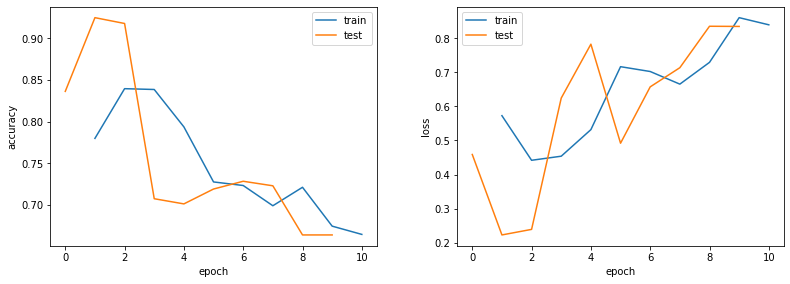

In [24]:
displayModelResult(history6_3, fitModel6_3, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=10)



*  If the momentum term is large then the learning rate should be kept smaller. A large value of momentum also means that the convergence will happen fast. But if both the momentum and learning rate are kept at large values, then you might skip the minimum with a huge step. A small value of momentum cannot reliably avoid local minima, and can also slow down the training of the system. 





*   **Adam**(adaptive moment estimation) realizes the benefits of both Adaptive Gradient Algorithm and Root Mean Square Propagation.Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).



In [137]:
model6_4 = createModel([2048, 1024, 4096, 1024], optimizerFunc= optimizers.Adam(learning_rate=0.001))
history6_4, fitModel6_4 = fitModel(model6_4, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=10)

Epoch 1/10
161/161 [==============================] - 144s 891ms/step - loss: 1.6949 - accuracy: 0.6590 - val_loss: 0.2806 - val_accuracy: 0.9099
Epoch 2/10
161/161 [==============================] - 143s 886ms/step - loss: 0.3685 - accuracy: 0.8636 - val_loss: 0.2598 - val_accuracy: 0.9053
Epoch 3/10
161/161 [==============================] - 143s 891ms/step - loss: 0.3298 - accuracy: 0.8820 - val_loss: 0.1863 - val_accuracy: 0.9317
Epoch 4/10
161/161 [==============================] - 142s 885ms/step - loss: 0.2885 - accuracy: 0.8970 - val_loss: 0.2089 - val_accuracy: 0.9286
Epoch 5/10
161/161 [==============================] - 143s 887ms/step - loss: 0.2663 - accuracy: 0.9022 - val_loss: 0.1794 - val_accuracy: 0.9379
Epoch 6/10
161/161 [==============================] - 142s 884ms/step - loss: 0.2599 - accuracy: 0.9044 - val_loss: 0.1889 - val_accuracy: 0.9309
Epoch 7/10
161/161 [==============================] - 142s 885ms/step - loss: 0.2664 - accuracy: 0.8977 - val_loss: 0.1971 -

Train data predictions are:
[2 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 2 0 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.97      0.48      0.65       460
           1       0.97      0.60      0.74      1266
           2       0.83      1.00      0.90      3418

    accuracy                           0.85      5144
   macro avg       0.92      0.70      0.76      5144
weighted avg       0.87      0.85      0.84      5144

Test Data Report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69       116
           1       0.95      0.68      0.79       317
           2       0.85      1.00      0.92       855

    accuracy                           0.87      1288
   macro avg       0.93      0.73      0.80      1288
weighted avg       0.89      0.87      0.86      1288



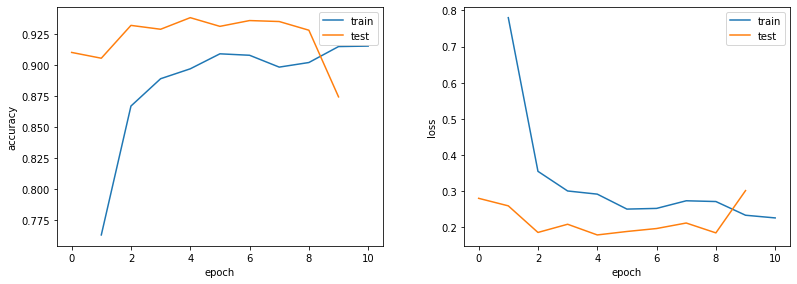

In [138]:
displayModelResult(history6_4, fitModel6_4, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=10)

## 7. Analyze number of epochs

In [139]:
model7 = createModel([2048, 1024, 4096, 1024], optimizerFunc= optimizers.Adam(learning_rate=0.001))
history7, fitModel7 = fitModel(model7, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=20)

Epoch 1/20
161/161 [==============================] - 144s 894ms/step - loss: 1.9343 - accuracy: 0.6731 - val_loss: 0.2879 - val_accuracy: 0.8843
Epoch 2/20
161/161 [==============================] - 143s 891ms/step - loss: 0.3010 - accuracy: 0.8855 - val_loss: 0.3062 - val_accuracy: 0.8843
Epoch 3/20
161/161 [==============================] - 143s 891ms/step - loss: 0.3248 - accuracy: 0.8798 - val_loss: 0.3530 - val_accuracy: 0.8595
Epoch 4/20
161/161 [==============================] - 143s 890ms/step - loss: 0.2692 - accuracy: 0.8947 - val_loss: 0.2111 - val_accuracy: 0.9208
Epoch 5/20
161/161 [==============================] - 143s 891ms/step - loss: 0.2864 - accuracy: 0.8919 - val_loss: 0.1884 - val_accuracy: 0.9301
Epoch 6/20
161/161 [==============================] - 143s 892ms/step - loss: 0.2538 - accuracy: 0.9131 - val_loss: 0.1789 - val_accuracy: 0.9371
Epoch 7/20
161/161 [==============================] - 144s 894ms/step - loss: 0.2517 - accuracy: 0.9107 - val_loss: 0.2111 -

Train data predictions are:
[0 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[0 0 0 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       460
           1       0.99      0.38      0.55      1266
           2       0.81      0.99      0.89      3418

    accuracy                           0.84      5144
   macro avg       0.89      0.78      0.79      5144
weighted avg       0.86      0.84      0.81      5144

Test Data Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       116
           1       0.98      0.42      0.59       317
           2       0.82      0.98      0.89       855

    accuracy                           0.84      1288
   macro avg       0.89      0.79      0.80      1288
weighted avg       0.86      0.84      0.82      1288



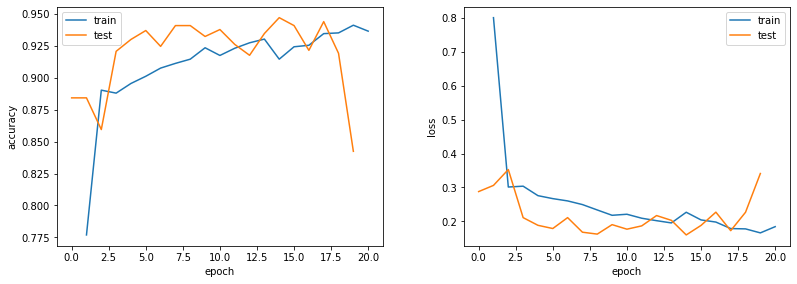

In [140]:
displayModelResult(history7, fitModel7, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=20)



*   Usually in neural networks we need to identify a large number of parameters that are not interdependent. To do this, we need a large amount of labeled data. This is difficult both in terms of time and data volume. So instead of using a sufficient amount of data, we train the model on the data set several times. As this process is done step by step and gets better it can improve the result.

* If the amount of data is sufficient, our need to use multiple epochs will also be reduced.







*   When the number of epochs increases, our model continues to learn training data so much that it even learns the noise in the data. This causes its performance on training data to be strong and on test data to be weak.
* To solve this problem, we can start with a large number of epochs, and by analyzing the result, identify the point from which overfitting occurs and select that epochs number as the best number. We can also increase the amount of training data to achieve better results in fewer rounds.



## 8. Analyze differnet loss functions

In [141]:
model8 = createModel([2048, 1024, 4096, 1024], optimizerFunc= optimizers.Adam(learning_rate=0.001), lossFunc='mse')
history8, fitModel8 = fitModel(model8, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=20)

Epoch 1/20
161/161 [==============================] - 144s 893ms/step - loss: 0.2247 - accuracy: 0.6531 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 2/20
161/161 [==============================] - 143s 890ms/step - loss: 0.2277 - accuracy: 0.6584 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 3/20
161/161 [==============================] - 143s 890ms/step - loss: 0.2292 - accuracy: 0.6562 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 4/20
161/161 [==============================] - 143s 890ms/step - loss: 0.2280 - accuracy: 0.6580 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 5/20
161/161 [==============================] - 144s 893ms/step - loss: 0.2274 - accuracy: 0.6590 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 6/20
161/161 [==============================] - 143s 890ms/step - loss: 0.2282 - accuracy: 0.6577 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 7/20
161/161 [==============================] - 143s 889ms/step - loss: 0.2203 - accuracy: 0.6696 - val_loss: 0.2241 -

Train data predictions are:
[2 2 2 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 2 2 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144

Test Data Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33      0.27      1288
weighted avg       0.44      0.66      0.53      1288



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


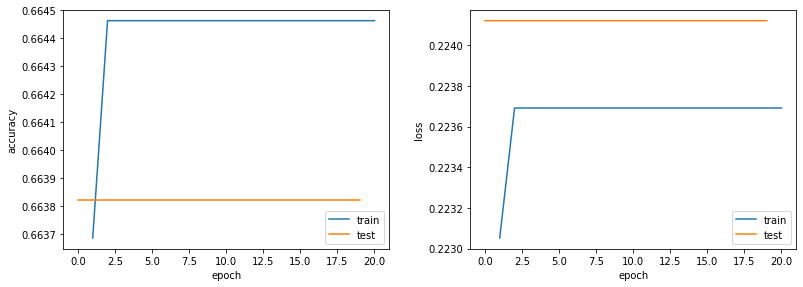

In [142]:
displayModelResult(history8, fitModel8, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=20)



*  
As we have seen, using this function caused the model to perform poorly for the following reasons: </br>

        - using MSE means that we assume that  data has been generated from a normal distribution. While in reality, a dataset that can be classified into n categories is not from a normal distribution.

        - if a binary classification model is trained with MSE Cost function, it is not guaranteed to minimize the Cost function. This is because MSE function expects real-valued inputs in range(-∞, ∞).

    We use MSE as a loss function for regression. 

## 9. Analyze Regularization Mathods



*   Techniques that seek to reduce overfitting (reduce generalization error) by keeping network weights small are referred to as regularization methods.



### L2

##### L2 updates the general cost function by adding another term known as the regularization term.

$ Cost function = Loss + Regularization term$

---



In [5]:
def createRegularModel(hiddenLayersShape,
                activationFunc='relu', 
                inputShape=(1,80,80), 
                optimizerFunc=optimizers.SGD(learning_rate=0.01), 
                lossFunc='categorical_crossentropy', 
                numberOfClass=3, 
                metrics=['accuracy'],
                regularizer=None,
                dropOut=0):
  
  inputLayer = layers.Input(shape=inputShape)
  flattenLayer = layers.Flatten()(inputLayer)
  hiddenLayers = [inputLayer, flattenLayer]

  for layerShape in hiddenLayersShape :
    hiddenLayers.append(layers.Dense(layerShape, activation=activationFunc, kernel_regularizer=regularizer)(hiddenLayers[-1]))
    if dropOut!=0: hiddenLayers.append(layers.Dropout(dropOut)(hiddenLayers[-1]))
  
  outputLayer = layers.Dense(numberOfClass, activation="softmax", kernel_regularizer=regularizer)(hiddenLayers[-1])

  model = models.Model(inputs=inputLayer, outputs=outputLayer)

  model.compile(optimizer=optimizerFunc, loss=lossFunc, metrics=metrics)

  return model

In [145]:
model9_1 = createRegularModel([2048, 1024, 4096, 1024], optimizerFunc= optimizers.Adam(learning_rate=0.001), regularizer=regularizers.L2(0.0001))
history9_1, fitModel9_1 = fitModel(model9_1, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=20)

Epoch 1/20
161/161 [==============================] - 145s 901ms/step - loss: 2.0484 - accuracy: 0.7041 - val_loss: 0.6694 - val_accuracy: 0.8835
Epoch 2/20
161/161 [==============================] - 144s 895ms/step - loss: 0.7113 - accuracy: 0.8555 - val_loss: 0.6111 - val_accuracy: 0.8835
Epoch 3/20
161/161 [==============================] - 145s 905ms/step - loss: 0.5752 - accuracy: 0.8872 - val_loss: 0.4310 - val_accuracy: 0.9161
Epoch 4/20
161/161 [==============================] - 145s 901ms/step - loss: 0.4990 - accuracy: 0.8924 - val_loss: 0.4750 - val_accuracy: 0.8898
Epoch 5/20
161/161 [==============================] - 144s 899ms/step - loss: 0.4337 - accuracy: 0.9039 - val_loss: 0.5293 - val_accuracy: 0.8703
Epoch 6/20
161/161 [==============================] - 145s 901ms/step - loss: 0.4463 - accuracy: 0.8930 - val_loss: 0.4600 - val_accuracy: 0.8797
Epoch 7/20
161/161 [==============================] - 144s 897ms/step - loss: 0.4378 - accuracy: 0.8876 - val_loss: 0.3461 -

Train data predictions are:
[2 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 0 0 ... 1 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       460
           1       0.68      0.98      0.80      1266
           2       0.98      0.84      0.91      3418

    accuracy                           0.87      5144
   macro avg       0.88      0.88      0.87      5144
weighted avg       0.91      0.87      0.88      5144

Test Data Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90       116
           1       0.71      0.99      0.82       317
           2       0.98      0.86      0.92       855

    accuracy                           0.89      1288
   macro avg       0.90      0.89      0.88      1288
weighted avg       0.92      0.89      0.89      1288



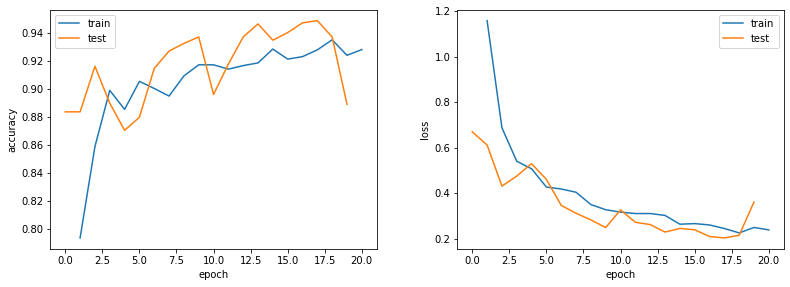

In [147]:
displayModelResult(history9_1, fitModel9_1, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=20)

### Dropout

##### At every iteration, it randomly selects some nodes and removes them along with all of their incoming and outgoing connections as shown below.So each iteration has a different set of nodes and this results in a different set of outputs. 
---



In [17]:
model9_2 = createRegularModel([2048, 1024, 4096, 1024], optimizerFunc= optimizers.Adam(learning_rate=0.001), dropOut=0.1)
history9_2, fitModel9_2 = fitModel(model9_2, trainData=dataTrainNormalized, testData=dataTestNormalized, epochs=20)

Epoch 1/20
161/161 [==============================] - 144s 887ms/step - loss: 1.5507 - accuracy: 0.6733 - val_loss: 0.3082 - val_accuracy: 0.8975
Epoch 2/20
161/161 [==============================] - 143s 891ms/step - loss: 0.3629 - accuracy: 0.8634 - val_loss: 0.2349 - val_accuracy: 0.9208
Epoch 3/20
161/161 [==============================] - 143s 891ms/step - loss: 0.3327 - accuracy: 0.8740 - val_loss: 0.2477 - val_accuracy: 0.9006
Epoch 4/20
161/161 [==============================] - 143s 888ms/step - loss: 0.3058 - accuracy: 0.8837 - val_loss: 0.2215 - val_accuracy: 0.9224
Epoch 5/20
161/161 [==============================] - 144s 893ms/step - loss: 0.2782 - accuracy: 0.9008 - val_loss: 0.2821 - val_accuracy: 0.8804
Epoch 6/20
161/161 [==============================] - 143s 886ms/step - loss: 0.2742 - accuracy: 0.9002 - val_loss: 0.3085 - val_accuracy: 0.8952
Epoch 7/20
161/161 [==============================] - 142s 885ms/step - loss: 0.2710 - accuracy: 0.9031 - val_loss: 0.2049 -

Train data predictions are:
[2 0 0 ... 2 2 2]
Train data expection are:
[0 0 0 ... 2 2 2]
Test data predictions are:
[2 0 0 ... 2 2 2]
Test data expection are:
[0 0 0 ... 2 2 2]
Train Data Report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       460
           1       0.89      0.91      0.90      1266
           2       0.94      0.97      0.95      3418

    accuracy                           0.93      5144
   macro avg       0.94      0.87      0.90      5144
weighted avg       0.93      0.93      0.93      5144

Test Data Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79       116
           1       0.89      0.93      0.91       317
           2       0.94      0.97      0.96       855

    accuracy                           0.93      1288
   macro avg       0.95      0.85      0.89      1288
weighted avg       0.94      0.93      0.93      1288



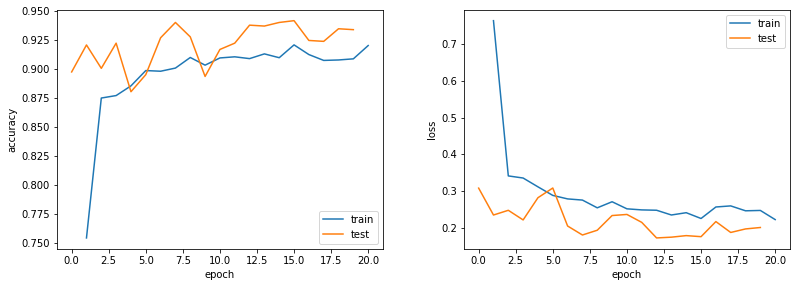

In [22]:
displayModelResult(history9_2, fitModel9_2, dataTrainNormalizedSorted, dataTestNormalizedSorted, epochs=20)